In [1]:
import numpy as np
import os
from  matplotlib import pyplot as plt
import keras
import shutil
import re
import tensorflow as tf
import nltk
from nltk.corpus import stopwords
import string
import json 
from time import time
import pickle 
from keras.applications.vgg16 import VGG16
from keras.applications.resnet import ResNet50,preprocess_input,decode_predictions
from keras.utils import load_img, img_to_array
from keras.models import Model,load_model
#from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Input, Dense, Dropout, Embedding,LSTM
from keras.layers import Add 
from keras_preprocessing.sequence import pad_sequences

In [2]:
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))
sess

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: NVIDIA GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5



In [32]:
""" import random,shutil

os.mkdir("data/train")
os.mkdir("data/val")
os.mkdir("data/test")

def moveTrainTestList(trainNum=6000,valNum=1091,testNum=1000):
    
    images = os.listdir("data/Images/")
    trainImages = random.sample(images,trainNum)
    for image in trainImages:
        shutil.move("data/Images/"+image,"data/train/")
    
    images = os.listdir("data/Images/")
    valImages = random.sample(images,k=valNum)
    for image in valImages:
        shutil.move("data/Images/"+image,"data/val/")
    
    images = os.listdir("data/Images/")
    testImages = random.sample(images,k=testNum)
    for image in testImages:
        shutil.move("data/Images/"+image,"data/test/")
 
   
moveTrainTestList()
 """


In [33]:
with open(r"D:/Python Project/Image Caption/data/captions.txt") as filepath:
    captions = filepath.read()
    filepath.close()

In [4]:
#captions

In [34]:
captions = captions.split("\n")[:-1]
captions[0]
#captions

'image,caption'

In [35]:
type(captions[0])

str

In [36]:
len(captions)

40455

In [37]:
captions.remove('image,caption')

In [38]:
descriptions={}
for caption in  captions:
    
    imageName,description = caption.split(".jpg,")

    
    img_name = imageName.split(".")[0]
   
    cap = description

    if descriptions.get(img_name) == None:
        descriptions[img_name]=[]
    
    descriptions[img_name].append(cap)

In [39]:
descriptions["3637013_c675de7705"]

["A couple stands close at the water 's edge .",
 'The two people stand by a body of water and in front of bushes in fall .',
 'Two people hold each other near a pond .',
 'Two people stand by the water .',
 'Two people stand together on the edge of the water on the grass .']

In [40]:
def clean_text(sample):

    sample = sample.lower()

    sample = re.sub("[^a-z]+"," ",sample)
 
    sample = sample.split()

    sample = [s for s in sample if len(s)>1]

    sample = " ".join(sample)

    return sample

In [41]:
clean_text("A child in a pink dress is climbing up a set of stairs in an entry way .")

'child in pink dress is climbing up set of stairs in an entry way'

In [42]:
for key, desc_list in descriptions.items():
    for i in range(len(desc_list)):
        desc_list[i] = clean_text(desc_list[i])
    


In [43]:
descriptions["1000268201_693b08cb0e"]

['child in pink dress is climbing up set of stairs in an entry way',
 'girl going into wooden building',
 'little girl climbing into wooden playhouse',
 'little girl climbing the stairs to her playhouse',
 'little girl in pink dress going into wooden cabin']

In [44]:
f = open("descriptions.txt","w")
f.write(str(descriptions))
f.close()

In [45]:
f = open("descriptions.txt","r")
descriptions = f.read()
f.close()

json_acceptable_string = descriptions.replace("'","\"")

descriptions = json.loads(json_acceptable_string)

In [46]:
descriptions

{'1000268201_693b08cb0e': ['child in pink dress is climbing up set of stairs in an entry way',
  'girl going into wooden building',
  'little girl climbing into wooden playhouse',
  'little girl climbing the stairs to her playhouse',
  'little girl in pink dress going into wooden cabin'],
 '1001773457_577c3a7d70': ['black dog and spotted dog are fighting',
  'black dog and tri colored dog playing with each other on the road',
  'black dog and white dog with brown spots are staring at each other in the street',
  'two dogs of different breeds looking at each other on the road',
  'two dogs on pavement moving toward each other'],
 '1002674143_1b742ab4b8': ['little girl covered in paint sits in front of painted rainbow with her hands in bowl',
  'little girl is sitting in front of large painted rainbow',
  'small girl in the grass plays with fingerpaints in front of white canvas with rainbow on it',
  'there is girl with pigtails sitting in front of rainbow painting',
  'young girl with p

In [47]:
vocabulary = set()

for key in descriptions.keys():
    [vocabulary.update(i.split()) for i in descriptions[key]]

print("Vocabulary size : %d" % len(vocabulary))

Vocabulary size : 8424


In [48]:
all_vocab = []

for key in descriptions.keys():
    [all_vocab.append(i) for des in descriptions[key] for i in des.split()]

print("Vocabulary size: %d" % len(all_vocab))
print(all_vocab[:15])

Vocabulary size: 373796
['child', 'in', 'pink', 'dress', 'is', 'climbing', 'up', 'set', 'of', 'stairs', 'in', 'an', 'entry', 'way', 'girl']


In [49]:
import collections

from cv2 import threshold

counter = collections.Counter(all_vocab)

dic_ = dict(counter)

threshold_value = 10

sorted_dic = sorted(dic_.items(),reverse=True,key=lambda x:x[1])

sorted_dic = [x for x in sorted_dic if x[1] > threshold_value]

all_vocab = [x[0] for x in sorted_dic]
print(all_vocab[:15])

['in', 'the', 'on', 'is', 'and', 'dog', 'with', 'man', 'of', 'two', 'white', 'black', 'boy', 'are', 'woman']


In [50]:
len(all_vocab)

1845

Loading Training Testing Data

In [51]:

def createTrainTestList():
    
 
    train = os.listdir("data/train/")
    val = os.listdir("data/val/")
    test = os.listdir("data/test/")

    return train,val,test





In [52]:

train,val,test = createTrainTestList()


In [53]:
test

['1003163366_44323f5815.jpg',
 '102351840_323e3de834.jpg',
 '102455176_5f8ead62d5.jpg',
 '1042020065_fb3d3ba5ba.jpg',
 '1056359656_662cee0814.jpg',
 '1072153132_53d2bb1b60.jpg',
 '1084040636_97d9633581.jpg',
 '1087168168_70280d024a.jpg',
 '1088767354_2acee738cf.jpg',
 '1089181217_ee1167f7af.jpg',
 '1093716555_801aacef79.jpg',
 '1095590286_c654f7e5a9.jpg',
 '1096165011_cc5eb16aa6.jpg',
 '109738763_90541ef30d.jpg',
 '109823394_83fcb735e1.jpg',
 '111537222_07e56d5a30.jpg',
 '1117972841_2b9261f95f.jpg',
 '1122944218_8eb3607403.jpg',
 '1131800850_89c7ffd477.jpg',
 '1132772170_600610c5df.jpg',
 '1143882946_1898d2eeb9.jpg',
 '1148238960_f8cacec2fc.jpg',
 '116409198_0fe0c94f3b.jpg',
 '1167908324_8caab45e15.jpg',
 '1178705300_c224d9a4f1.jpg',
 '1193116658_c0161c35b5.jpg',
 '1197800988_7fb0ca4888.jpg',
 '1225443522_1633e7121f.jpg',
 '1227655020_b11a1bb112.jpg',
 '1231229740_8dcbf80bfb.jpg',
 '124195430_d14028660f.jpg',
 '1244485675_822e6efe60.jpg',
 '124881487_36e668145d.jpg',
 '1252396628_eb81d

In [54]:
train_descriptions = {}

for t in train:
    t = t[:-4]
    train_descriptions[t] = []
    
    for cap in descriptions[t]:
        cap_to_append = "startseq " +cap+" endseq" 
        train_descriptions[t].append(cap_to_append)

In [55]:
val

['1000268201_693b08cb0e.jpg',
 '1015118661_980735411b.jpg',
 '1022454428_b6b660a67b.jpg',
 '103195344_5d2dc613a3.jpg',
 '1032122270_ea6f0beedb.jpg',
 '105342180_4d4a40b47f.jpg',
 '1056873310_49c665eb22.jpg',
 '1067180831_a59dc64344.jpg',
 '1075716537_62105738b4.jpg',
 '1077546505_a4f6c4daa9.jpg',
 '109202756_b97fcdc62c.jpg',
 '109260218_fca831f933.jpg',
 '1100214449_d10861e633.jpg',
 '1130369873_d80a1aa59c.jpg',
 '1138784872_69ade3f2ab.jpg',
 '1141739219_2c47195e4c.jpg',
 '1159574340_99ba8c3c59.jpg',
 '1167662968_e466f1e80a.jpg',
 '1174629344_a2e1a2bdbf.jpg',
 '1191338263_a4fa073154.jpg',
 '1245022983_fb329886dd.jpg',
 '125319704_49ead3463c.jpg',
 '1253264731_e7c689eca5.jpg',
 '1260816604_570fc35836.jpg',
 '1262583859_653f1469a9.jpg',
 '1263126002_881ebd7ac9.jpg',
 '1277743944_f4e8c78403.jpg',
 '1298866571_b4c496b71c.jpg',
 '1304100320_c8990a1539.jpg',
 '1305564994_00513f9a5b.jpg',
 '131632409_4de0d4e710.jpg',
 '1319634306_816f21677f.jpg',
 '1324816249_86600a6759.jpg',
 '1332208215_fa8

In [56]:
val_descriptions = {}

for t in val:
    t = t[:-4]
  
    val_descriptions[t] = []
    for cap in descriptions[t]:
        cap_to_append = "startseq " +cap+" endseq" 
        val_descriptions[t].append(cap_to_append)

In [57]:
model = ResNet50(weights="imagenet",input_shape=(224,224,3))

In [58]:
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [59]:
customModel = Model(model.input,model.layers[-2].output)

In [60]:
def preprocess_image(img):
    img = load_img(img,target_size=(224,224))
    img = img_to_array(img)
    img = np.expand_dims(img,axis=0)
    img = preprocess_input(img)
    return img

In [61]:
def encode_image(img):
    img = preprocess_image(img)
    feature_vector = customModel.predict(img)
    feature_vector = feature_vector.reshape(feature_vector.shape[1],)
    return feature_vector

In [62]:
trainPath="./data/train/"
testPath="./data/test/"
valPath="./data/val/"

In [63]:
start = time()

valX=[]
valY=[]


for ix, img in enumerate(val):
    
    img=valPath+val[ix]
   
    valX.append(preprocess_image(img))
    valY.append(val_descriptions[img.split("/")[3][:-4]])
 

    if ix%100==0:
        print("Encoding val image - "+str(ix))

print("Time taken in seconds = ", time()-start)

./data/val/1000268201_693b08cb0e.jpg
Encoding val image - 0
./data/val/1015118661_980735411b.jpg
./data/val/1022454428_b6b660a67b.jpg
./data/val/103195344_5d2dc613a3.jpg
./data/val/1032122270_ea6f0beedb.jpg
./data/val/105342180_4d4a40b47f.jpg
./data/val/1056873310_49c665eb22.jpg
./data/val/1067180831_a59dc64344.jpg
./data/val/1075716537_62105738b4.jpg
./data/val/1077546505_a4f6c4daa9.jpg
./data/val/109202756_b97fcdc62c.jpg
./data/val/109260218_fca831f933.jpg
./data/val/1100214449_d10861e633.jpg
./data/val/1130369873_d80a1aa59c.jpg
./data/val/1138784872_69ade3f2ab.jpg
./data/val/1141739219_2c47195e4c.jpg
./data/val/1159574340_99ba8c3c59.jpg
./data/val/1167662968_e466f1e80a.jpg
./data/val/1174629344_a2e1a2bdbf.jpg
./data/val/1191338263_a4fa073154.jpg
./data/val/1245022983_fb329886dd.jpg
./data/val/125319704_49ead3463c.jpg
./data/val/1253264731_e7c689eca5.jpg
./data/val/1260816604_570fc35836.jpg
./data/val/1262583859_653f1469a9.jpg
./data/val/1263126002_881ebd7ac9.jpg
./data/val/127774394

In [64]:
start = time()

encoding_train={}

for ix, img in enumerate(train):
    
    img=trainPath+train[ix]
   
    
    encoding_train[img.split("/")[3][:-4]] = encode_image(img)

    if ix%100==0:
        print("Encoding image - "+str(ix))

print("Time taken in seconds = ", time()-start)



1/1 [==============================] - 7s 7s/step
Encoding image - 0
1/1 [==============================] - 0s 41ms/step
Encoding image - 100
1/1 [==============================] - 0s 35ms/step
Encoding image - 200
1/1 [==============================] - 0s 31ms/step
Encoding image - 300
1/1 [==============================] - 0s 30ms/step
Encoding image - 400
1/1 [==============================] - 0s 32ms/step
Encoding image - 500
1/1 [==============================] - 0s 29ms/step
Encoding image - 600
1/1 [==============================] - 0s 32ms/step
Encoding image - 700
1/1 [==============================] - 0s 30ms/step
Encoding image - 800
1/1 [==============================] - 0s 34ms/step
Encoding image - 900
1/1 [==============================] - 0s 38ms/step
Encoding image - 1000
1/1 [==============================] - 0s 32ms/step
Encoding image - 1100
1/1 [==============================] - 0s 31ms/step
Encoding image - 1200
1/1 [==============================] - 0s 33ms/step


In [65]:
with open("encoded_train_images.pkl","wb") as encoded_pickle:
    pickle.dump(encoding_train,encoded_pickle)

In [66]:
import pickle as pkl
with open("encoded_train_images.pkl","rb") as f:
    encoding_train = pkl.load(f)

In [67]:
start = time()

encoding_test={}

for ix, img in enumerate(test):
    img=testPath + test[ix]
    encoding_test[img.split("/")[3][:-4]] = encode_image(img)

    if ix%100==0:
        print("Encoding image - "+str(ix))

print("Time taken in seconds = ", time()-start)

1/1 [==============================] - 0s 72ms/step
Encoding image - 0
1/1 [==============================] - 0s 55ms/step
Encoding image - 100
1/1 [==============================] - 0s 55ms/step
Encoding image - 200
1/1 [==============================] - 0s 52ms/step
Encoding image - 300
1/1 [==============================] - 0s 66ms/step
Encoding image - 400
1/1 [==============================] - 0s 64ms/step
Encoding image - 500
1/1 [==============================] - 0s 61ms/step
Encoding image - 600
1/1 [==============================] - 0s 66ms/step
Encoding image - 700
1/1 [==============================] - 0s 63ms/step
Encoding image - 800
1/1 [==============================] - 0s 67ms/step
Encoding image - 900
1/1 [==============================] - 0s 61ms/step
Time taken in seconds =  173.97896647453308


In [68]:
with open("encoded_test_images.pkl","wb") as encoded_pickle:
    pickle.dump(encoding_test,encoded_pickle)

In [69]:
import pickle as pkl
with open("encoded_test_images.pkl","rb") as f:
    encoding_test = pkl.load(f)

In [70]:
ix = 0
word_to_idx = {}
idx_to_word = {}

for e in all_vocab:
    word_to_idx[e] = ix
    idx_to_word[ix] = e
    ix +=1
ix

1845

In [71]:
len(word_to_idx)

1845

In [72]:
word_to_idx["startseq"] = 1845
word_to_idx["endseq"] = 1846

idx_to_word[1845] = "startseq"
idx_to_word[1846] = "endseq"



len(word_to_idx)


1847

In [73]:
vocab_size = len(idx_to_word) + 1
print(vocab_size)

1848


In [74]:
all_captions_len = []

for key in train_descriptions.keys():
    for cap in train_descriptions[key]:
        all_captions_len.append(len(cap.split()))

max_len = max(all_captions_len)
print(max_len)

35


In [75]:
def data_generator(train_descriptions,encoding_train,word_to_idx,max_len,num_photos_per_batch):
    
    X1, X2, y = [], [], []

    n = 0

    while True:

        for key, desc_list in train_descriptions.items():
            n +=1

            photo = encoding_train[key]

            for desc in desc_list:

                seq = [word_to_idx[word] for word in desc.split() if word in word_to_idx]
                
                for i in range(1,len(seq)):
                    
                    in_seq = seq[0:i]
                    out_seq = seq[i]

                    in_seq = pad_sequences([in_seq], maxlen = max_len, value=0, padding="post")[0]

                    out_seq = to_categorical([out_seq],num_classes = vocab_size)[0]

                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)

            if n==num_photos_per_batch:
                u = np.array(X1)
                v = np.array(X2)
                w = np.array(y)
                yield([u,v],w)
                X1, X2, y = [], [], []
                n = 0

In [76]:
f = open("glove_6B_50d.txt",encoding="utf8")

In [77]:
embedding_index = {}

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:],dtype="float")

    embedding_index[word] = coefs

f.close()

In [78]:
embedding_index

{'the': array([ 4.1800e-01,  2.4968e-01, -4.1242e-01,  1.2170e-01,  3.4527e-01,
        -4.4457e-02, -4.9688e-01, -1.7862e-01, -6.6023e-04, -6.5660e-01,
         2.7843e-01, -1.4767e-01, -5.5677e-01,  1.4658e-01, -9.5095e-03,
         1.1658e-02,  1.0204e-01, -1.2792e-01, -8.4430e-01, -1.2181e-01,
        -1.6801e-02, -3.3279e-01, -1.5520e-01, -2.3131e-01, -1.9181e-01,
        -1.8823e+00, -7.6746e-01,  9.9051e-02, -4.2125e-01, -1.9526e-01,
         4.0071e+00, -1.8594e-01, -5.2287e-01, -3.1681e-01,  5.9213e-04,
         7.4449e-03,  1.7778e-01, -1.5897e-01,  1.2041e-02, -5.4223e-02,
        -2.9871e-01, -1.5749e-01, -3.4758e-01, -4.5637e-02, -4.4251e-01,
         1.8785e-01,  2.7849e-03, -1.8411e-01, -1.1514e-01, -7.8581e-01]),
 ',': array([ 0.013441,  0.23682 , -0.16899 ,  0.40951 ,  0.63812 ,  0.47709 ,
        -0.42852 , -0.55641 , -0.364   , -0.23938 ,  0.13001 , -0.063734,
        -0.39575 , -0.48162 ,  0.23291 ,  0.090201, -0.13324 ,  0.078639,
        -0.41634 , -0.15428 ,  0.1

In [79]:
def get_embedding_output():

    emb_dim = 50
    embedding_output = np.zeros((vocab_size, emb_dim))

    for word, idx in word_to_idx.items():
        embedding_vector = embedding_index.get(word)

        if embedding_vector is not None:
            embedding_output[idx] = embedding_vector
    
    return embedding_output

embedding_output = get_embedding_output()


In [80]:
embedding_output.shape

(1848, 50)

In [81]:
input_img_fea = Input(shape=(2048,))
inp_img1 = Dropout(0.3)(input_img_fea)
inp_img2 = Dense(256,activation="relu")(inp_img1)


In [82]:
input_cap = Input(shape=(max_len,))
input_cap1 = Embedding(input_dim=vocab_size, output_dim=50,mask_zero=True)(input_cap)
input_cap2 = Dropout(0.3)(input_cap1)
input_cap3 = LSTM(256)(input_cap2)

In [83]:
decoder1 = Add()([inp_img2,input_cap3])
decoder2 = Dense(256,activation="relu")(decoder1)
outputs = Dense(vocab_size,activation="softmax")(decoder2)

model = Model(inputs=[input_img_fea,input_cap],outputs=outputs)

In [84]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 35)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 35, 50)       92400       ['input_3[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 2048)         0           ['input_2[0][0]']                
                                                                                            

In [85]:
model.layers[2].set_weights([embedding_output])
model.layers[2].trainable = False

In [86]:
model.compile(loss="categorical_crossentropy",optimizer="adam")

In [95]:
epochs = 10
number_pics_per_bath = 10 
steps = len(train_descriptions)//number_pics_per_bath

In [89]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  1


In [96]:


for i in range(epochs):
    generator = data_generator(train_descriptions=train_descriptions,encoding_train=encoding_train,word_to_idx=word_to_idx,max_len=max_len,num_photos_per_batch=number_pics_per_bath)
    model.fit(generator,epochs=10,steps_per_epoch=steps,verbose=1)
    model.save("./model_weights/model_"+str(i)+".h5")

Epoch 1/10
600/600 [==============================] - 110s 182ms/step - loss: 3.1666
Epoch 2/10
600/600 [==============================] - 127s 212ms/step - loss: 3.1020
Epoch 3/10
600/600 [==============================] - 107s 178ms/step - loss: 3.0550
Epoch 4/10
600/600 [==============================] - 95s 158ms/step - loss: 3.0091
Epoch 5/10
600/600 [==============================] - 95s 157ms/step - loss: 2.9683
Epoch 6/10
600/600 [==============================] - 93s 154ms/step - loss: 2.9279
Epoch 7/10
600/600 [==============================] - 93s 155ms/step - loss: 2.8875
Epoch 8/10
600/600 [==============================] - 93s 155ms/step - loss: 2.8539
Epoch 9/10
600/600 [==============================] - 93s 154ms/step - loss: 2.8227
Epoch 10/10
600/600 [==============================] - 94s 157ms/step - loss: 2.7896
Epoch 1/10
600/600 [==============================] - 93s 155ms/step - loss: 2.7630
Epoch 2/10
600/600 [==============================] - 93s 155ms/step - l

In [97]:
model = load_model("model_weights\model_9.h5")

In [98]:
from msilib import sequence


def predict_caption(photo):
    in_text = "startseq"

    for i in range(max_len):
        sequence = [word_to_idx[w] for w in in_text.split() if w in word_to_idx]
    
        sequence = pad_sequences([sequence],maxlen=max_len,padding="post")
        
        y_pred = model.predict([photo,sequence])
       
        y_pred = y_pred.argmax()
        word = idx_to_word[y_pred]
        in_text += " " + word 

        if word == "endseq":
            break
        
    final_caption = in_text.split()
    final_caption = final_caption[1:-1]
    final_caption = " ".join(final_caption)

    return final_caption

In [101]:
img_path = "data/test/"

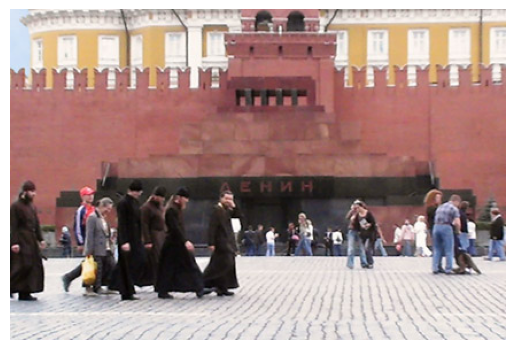

1/1 [==============================] - 0s 34ms/step
group of people stand outside building


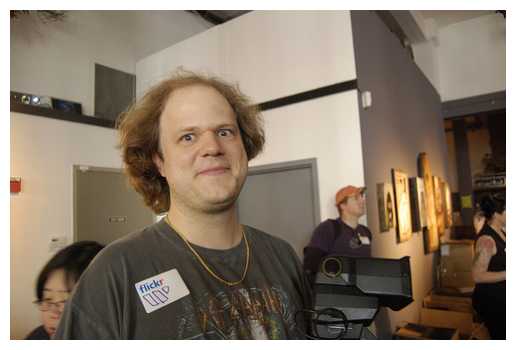

1/1 [==============================] - 0s 31ms/step
man in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in


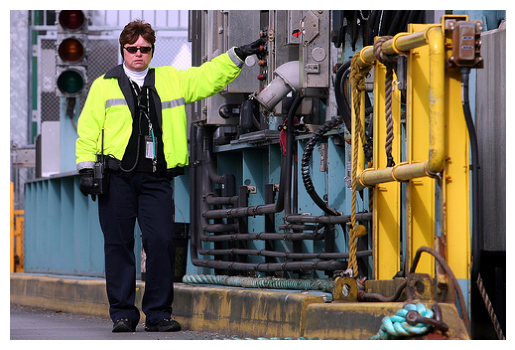

1/1 [==============================] - 0s 32ms/step
man and woman sitting on bench front of truck


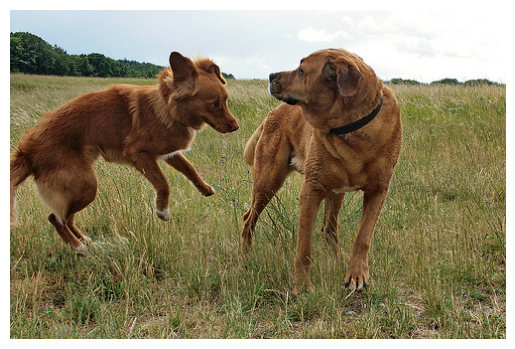

1/1 [==============================] - 0s 34ms/step
two brown dogs are running through the grass


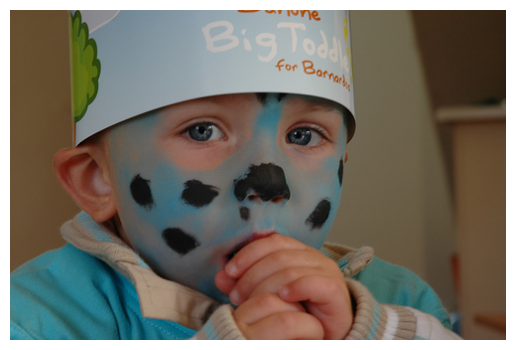

1/1 [==============================] - 0s 34ms/step
boy with his eyes closed her finger is holding


In [102]:
for i in range(5):
    rn = np.random.randint(0,1000)
    img_name = list(encoding_test.keys())[rn]
    photo = encoding_test[img_name].reshape((1,2048))

    i = plt.imread(img_path+img_name+".jpg")
    plt.imshow(i)
    plt.axis("off")
    plt.show()

    caption = predict_caption(photo)
    print(caption)